In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LogR

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, f1_score
from sklearn.utils import resample
from matplotlib import pyplot as plt
import numpy as np

def evaluate_logistic_regression_performance(model, X_test, y_test, y_pred_prob, feature_names, n_bootstraps=1000, alpha=0.95):
    """
    Evaluate the performance of a Logistic Regression model, including feature importance, ROC curve,
    precision-recall curve, F1 score, and confusion matrix.

    Parameters:
    - model: The trained logistic regression model.
    - X_test: Test feature data.
    - y_test: True labels for the test set.
    - y_pred_prob: Predicted probabilities from the model for the test set.
    - feature_names: List of feature names.
    - n_bootstraps: Number of bootstraps for confidence interval calculation.
    - alpha: Confidence level for F1 score confidence intervals.
    """

    # Step 1: Feature Importance
    feature_importance = model.layers[0].get_weights()[0].flatten()
    sorted_idx = np.argsort(abs(feature_importance))[::-1]  # Sort by absolute value, descending
    sorted_feature_importance = feature_importance[sorted_idx]
    sorted_feature_names = np.array(feature_names)[sorted_idx]

    plt.figure(figsize=(10, 8))
    plt.barh(sorted_feature_names, sorted_feature_importance)
    plt.xlabel('Importance (Coefficient)')
    plt.title('Feature Importance in Logistic Regression Model')
    plt.show()

    # Step 2: ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Additional Step: F1 score, confidence intervals, and precision-recall curve
    def compute_confidence_interval(y_test, predictions, n_bootstraps=1000, alpha=0.95):
        bootstrapped_scores = []
        for i in range(n_bootstraps):
            indices = resample(np.arange(len(predictions)))
            if len(np.unique(y_test[indices])) < 2:
                continue
            score = f1_score(y_test[indices], predictions[indices])
            bootstrapped_scores.append(score)
        sorted_scores = np.array(bootstrapped_scores)
        sorted_scores.sort()
        lower = sorted_scores[int((1.0-alpha)/2.0 * len(sorted_scores))]
        upper = sorted_scores[int((alpha+(1.0-alpha)/2.0) * len(sorted_scores))]
        return lower, upper

    def performance(y_test, pred_probabilities):
        # Convert y_test to a NumPy array
        y_test = np.array(y_test)

        # Performance metrics
        fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
        roc_auc = roc_auc_score(y_test, pred_probabilities, average='micro')
        precision, recall, _ = precision_recall_curve(y_test, pred_probabilities)
        pr_auc = auc(recall, precision)
        optimal_cut_off = round(thresholds[np.argmax(tpr - fpr)], 4)
        predictions = np.where(pred_probabilities > optimal_cut_off, 1, 0)
        brier = round(f1_score(y_test, predictions), 3)

        # Compute F1 score
        f1 = f1_score(y_test, predictions)
        lower, upper = compute_confidence_interval(y_test, predictions)

        print("Area Under ROC Curve: %0.2f" % roc_auc)
        print("Brier score : {:.3f}".format(brier))
        print("F1 score : {:.2f}".format(f1))
        print("95% Confidence interval for F1 score: [{:.2f}, {:.2f}]".format(lower, upper))

        # Confusion matrix
        cm = confusion_matrix(y_test, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

    # Evaluate performance on test set
    performance(y_test, y_pred_prob)

# Example of usage:
# Assuming `model`, `X_test`, `y_test`, `y_pred_prob`, and `feature_names` are defined
# evaluate_logistic_regression_performance(model, X_test, y_test, y_pred_prob, feature_names)


In [2]:
import pandas as pd
# Load the variables from the CSV files for modeling
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_train-raw.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_test-raw.csv')
X_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_validation-raw.csv')

y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_train-raw.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_test-raw.csv')
y_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_validation-raw.csv')

print("X and y variables loaded from CSV files.")

# Check that the loaded data matches the original
print(f"Loaded X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Loaded X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Loaded X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}")

X and y variables loaded from CSV files.
Loaded X_train shape: (37802, 32), y_train shape: (37802, 1)
Loaded X_test shape: (4724, 32), y_test shape: (4724, 1)
Loaded X_validation shape: (4724, 32), y_validation shape: (4724, 1)


In [ ]:
# Extract column names from X_train
feature_names = X_train.columns.tolist()

In [ ]:
print(feature_names)

['F', 'M', 'asian', 'black', 'hispanic', 'native', 'other', 'unknown', 'white', 'sedative', 'vasopressor', 'vent', 'aniongap_avg', 'bicarbonate_avg', 'bun_avg', 'chloride_avg', 'creat', 'diasbp_mean', 'glucose_avg', 'heartrate_mean', 'hematocrit_avg', 'hemoglobin_avg', 'potassium_avg', 'resprate_mean', 'sodium_avg', 'spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr', 'wbc_avg', 'age']


In [ ]:
# Inspect the shape of X_train
print(f"Shape of X_train: {X_train.shape}")

# Look at the first row of X_train to help identify what might be missing
print(X_train.iloc[0])

# Now compare with feature_names
print(f"Number of feature names: {len(feature_names)}")

Shape of X_train: (37802, 32)
F                       True
M                      False
asian                   True
black                  False
hispanic               False
native                 False
other                  False
unknown                False
white                  False
sedative                   0
vasopressor                0
vent                       0
aniongap_avg           3.375
bicarbonate_avg     7.642857
bun_avg            16.696429
chloride_avg       26.696429
creat               0.801786
diasbp_mean        13.100379
glucose_avg        39.732143
heartrate_mean     20.630073
hematocrit_avg      8.746429
hemoglobin_avg      2.369643
potassium_avg       1.258929
resprate_mean       4.985072
sodium_avg         36.535714
spo2_mean          22.903423
sysbp_mean         25.250433
uo_rt_12hr          0.105387
uo_rt_24hr          0.091645
uo_rt_6hr           0.105387
wbc_avg             0.839286
age                61.071279
Name: 0, dtype: object
Number of feature n

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import time

# Ensure that X_train, X_test, X_validation are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')

# Ensure that y_train, y_test, y_validation are float32 or int32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_validation = y_validation.astype('float32')

# Define the Logistic Regression model using TensorFlow
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary crossentropy for binary classification
              metrics=['accuracy'])

# Measure the time taken for model fitting
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train,
                    epochs=150,  # You can adjust the number of epochs
                    validation_data=(X_validation, y_validation),
                    batch_size=32)  # Adjust batch size as needed

end_time = time.time()
print(f"Time taken to train the model: {end_time - start_time:.2f} seconds")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
# model.save('/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/logR_model(raw).h5')
# print("Model saved as 'final/logistic_regression_model(raw).h5'.")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary output (0 or 1)


Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1182/1182 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6005 - loss: 4.6532 - val_accuracy: 0.6734 - val_loss: 0.8782
Epoch 2/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7108 - loss: 0.7566 - val_accuracy: 0.7390 - val_loss: 0.6074
Epoch 3/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7438 - loss: 0.5874 - val_accuracy: 0.7466 - val_loss: 0.5456
Epoch 4/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7622 - loss: 0.5363 - val_accuracy: 0.7710 - val_loss: 0.5149
Epoch 5/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7708 - loss: 0.5229 - val_accuracy: 0.7680 - val_loss: 0.5123
Epoch 6/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7701 - loss: 0.5167 - val_accuracy: 0.7722 - val_loss: 0.5039
Epoch 7/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7680 - loss: 0.5189 - val_accuracy: 0.7707 - val_loss: 0.5108
Epoch 8/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7724 - loss: 0.5094 - val_

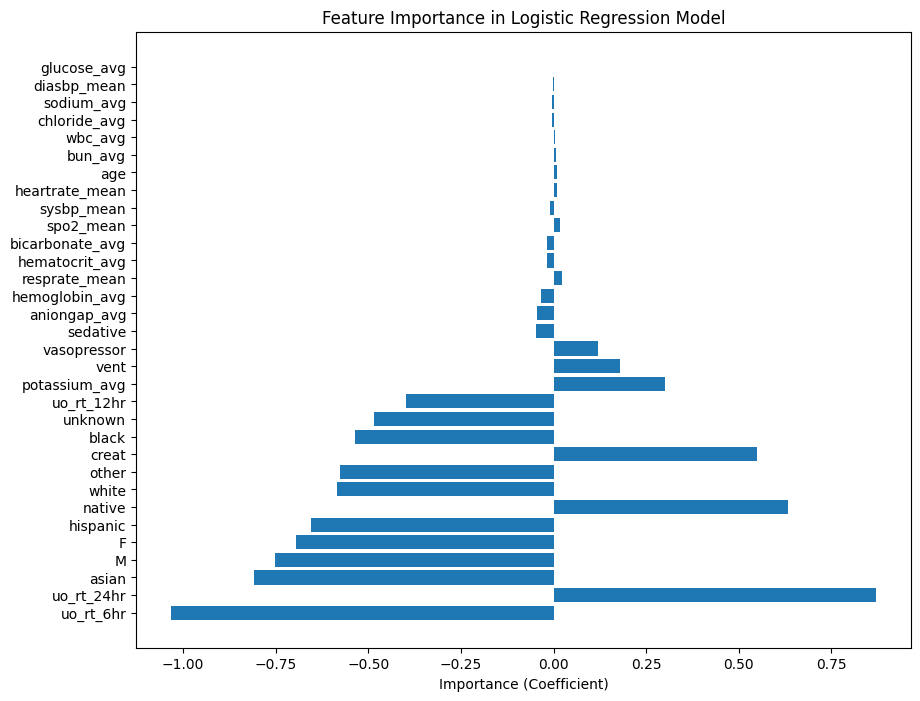

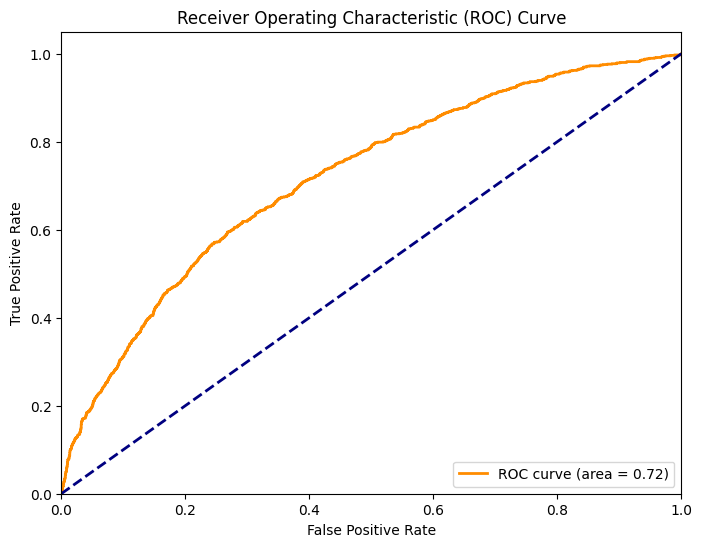

Area Under ROC Curve: 0.72
Brier score : 0.470
F1 score : 0.47
95% Confidence interval for F1 score: [0.45, 0.49]


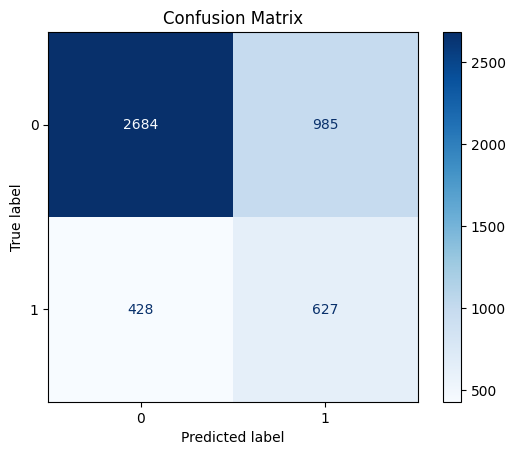

In [ ]:
evaluate_logistic_regression_performance(model, X_test, y_test, y_pred_prob, feature_names)

# CF

In [4]:
!pip install dice-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 60.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 1.5.3 which is incompatible.
xarray 2024.6.0 requires pandas>=2.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
# Select a specific instance from X_test (e.g., the first instance)
instance_index = 0  # Change this to select a different instance

# Create a query instance by using .iloc to correctly index into the DataFrame
query_instance = {feature_names[i]: X_test.iloc[instance_index, i] for i in range(len(feature_names))}

# Verify the query_instance structure
print(query_instance)

{'F': 0.0, 'M': 1.0, 'asian': 0.0, 'black': 0.0, 'hispanic': 0.0, 'native': 0.0, 'other': 0.0, 'unknown': 0.0, 'white': 1.0, 'sedative': 0.0, 'vasopressor': 0.0, 'vent': 0.0, 'aniongap_avg': 3.7323945, 'bicarbonate_avg': 7.5070424, 'bun_avg': 2.971831, 'chloride_avg': 31.084507, 'creat': 0.19295774, 'diasbp_mean': 21.446531, 'glucose_avg': 56.704224, 'heartrate_mean': 27.801447, 'hematocrit_avg': 8.956338, 'hemoglobin_avg': 2.5309858, 'potassium_avg': 1.1323943, 'resprate_mean': 7.6489797, 'sodium_avg': 41.19718, 'spo2_mean': 32.81675, 'sysbp_mean': 36.88651, 'uo_rt_12hr': 0.48337722, 'uo_rt_24hr': 0.49143362, 'uo_rt_6hr': 0.4853157, 'wbc_avg': 4.369718, 'age': 48.296272}


In [ ]:
import pandas as pd
# Load the variables from the CSV files for modeling
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_train-raw.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_test-raw.csv')
X_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_validation-raw.csv')

y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_train-raw.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_test-raw.csv')
y_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_validation-raw.csv')

print("X and y variables loaded from CSV files.")

# Check that the loaded data matches the original
print(f"Loaded X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Loaded X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Loaded X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}")

X and y variables loaded from CSV files.
Loaded X_train shape: (37802, 32), y_train shape: (37802, 1)
Loaded X_test shape: (4724, 32), y_test shape: (4724, 1)
Loaded X_validation shape: (4724, 32), y_validation shape: (4724, 1)


In [ ]:
import dice_ml
from dice_ml.utils import helpers
from dice_ml import Dice
import tensorflow as tf

# Ensure that X_train, X_test, X_validation are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')

# Ensure that y_train, y_test, y_validation are float32 or int32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_validation = y_validation.astype('float32')

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/logR_model(raw).h5')

# Re-attach the 'aki_stage' to the DataFrame before creating the DiCE data object
X_train_with_label = X_train.copy()
X_train_with_label['aki_stage'] = y_train

# Prepare DiCE data object
data = dice_ml.Data(dataframe=X_train_with_label, continuous_features=feature_names, outcome_name='aki_stage')

# Prepare DiCE model object
dice_model = dice_ml.Model(model=model, backend="TF2")  # Specify TensorFlow 2 as the backend

# Create a DiCE explainer
explainer = Dice(data, dice_model)

# Select a specific instance from X_test (e.g., the first instance)
instance_index = 0  # Change this to select a different instance

# Create a query instance as a DataFrame (single row)
query_instance_df = X_test.iloc[[instance_index]]

In [ ]:
# Generate counterfactual explanations
counterfactuals = explainer.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")
# Visualize the generated counterfactuals
counterfactuals.visualize_as_dataframe(show_only_changes=True)


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '72.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5201.4' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and wil

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.64898,41.197182,32.81675,36.886509,0.483377,0.491434,0.485316,4.369718,48.296272,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,83.5999984741211,-,-,-,1.0
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,105.0999984741211,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,78.5999984741211,-,-,-,1.0


In [ ]:
counterfactuals_pd = counterfactuals.cf_examples_list[0].final_cfs_df
# Option 2: If you want to see the entire table without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(counterfactuals_pd)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0  \
1  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
2  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
3  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
4  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   

   aniongap_avg  bicarbonate_avg   bun_avg   chloride_avg    creat   diasbp_mean  glucose_avg   
0    3.732394       7.507042       2.971831    31.084507   0.192958   21.446531   1826.599976  \
1    3.732394       7.507042       2.971831    31.084507   0.192958   21.446531   2157.300049   
2    3.732394       7.507042       2.971831    31.084507   0.192958   21.446531   5409.399902   
3    3.732394    

In [ ]:
cf_desired = explainer.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite", proximity_weight=1.5, diversity_weight=1.5)
cf_desired.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '33.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will r

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.64898,41.197182,32.81675,36.886509,0.483377,0.491434,0.485316,4.369718,48.296272,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,71.9000015258789,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,97.69999694824219,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0


In [ ]:
cf_desired_pd = cf_desired.cf_examples_list[0].final_cfs_df
# Option 2: If you want to see the entire table without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(cf_desired_pd)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0  \
1  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
2  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
3  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
4  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   

   aniongap_avg  bicarbonate_avg   bun_avg  chloride_avg    creat    diasbp_mean  glucose_avg   
0    3.732394       7.507042      2.971831    31.084507    0.192958   21.446531   2928.100098  \
1    3.732394       7.507042      2.971831    31.084507    0.192958   21.446531     56.704224   
2    3.732394       7.507042      2.971831    31.084507   19.400000   21.446531     56.704224   
3    3.732394    

In [ ]:
instance_index = 99  # Change this to select a different instance

# Create a query instance as a DataFrame (single row)
query_instance_df = X_test.iloc[[instance_index]]

In [ ]:
cf_desired_factor = explainer.generate_counterfactuals(query_instance_df, total_CFs=16, desired_class="opposite" )
cf_desired_factor.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '128.2' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will 

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,15.819445,94.166664,79.875,83.680557,1.153706,1.084544,1.550789,7.483333,66.764679,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,139.1999969482422,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,12.899999618530273,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,...,-,129.5,-,-,-,108.69999694824219,-,-,-,1.0
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
5,-,-,-,-,-,-,-,-,-,-,...,-,-,-,126.80000305175781,-,-,-,-,-,1.0
6,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,237.1999969482422,-,1.0
7,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
8,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,50.099998474121094,-,1.0
9,-,-,2.7755575615628914e-17,-,-,-,-,-,-,-,...,-,-,-,-,-,75.80000305175781,-,-,-,1.0


In [ ]:
# Access the counterfactual examples as a pandas DataFrame
cf_desired_factor_pd = cf_desired_factor.cf_examples_list[0].final_cfs_df

In [ ]:
# Option 2: If you want to see the entire table without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(cf_desired_factor_pd)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

     F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.7  \
1   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
2   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
3   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
4   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
5   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
6   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
7   0.0  1.0   0.2    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
8   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   


In [6]:
# Extract column names from X_train
feature_names = X_train.columns.tolist()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '51.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.8' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is depreca

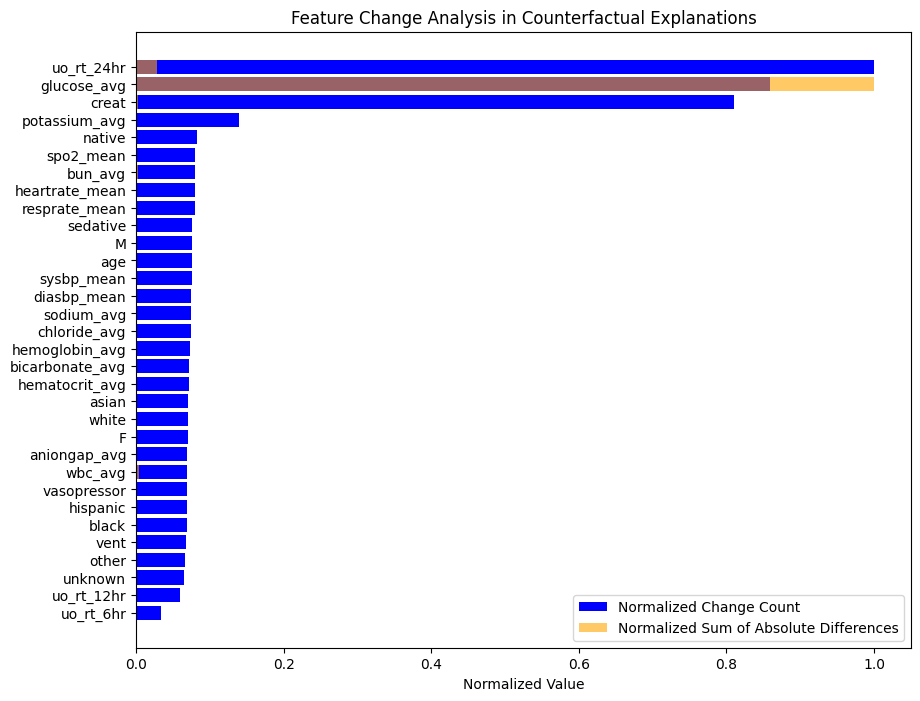

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette score is 0.1299


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette score is 0.1181


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette score is 0.1177


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette score is 0.0864


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette score is 0.0916


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the average silhouette score is 0.0839


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the average silhouette score is 0.0904


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the average silhouette score is 0.1118


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the average silhouette score is 0.0981


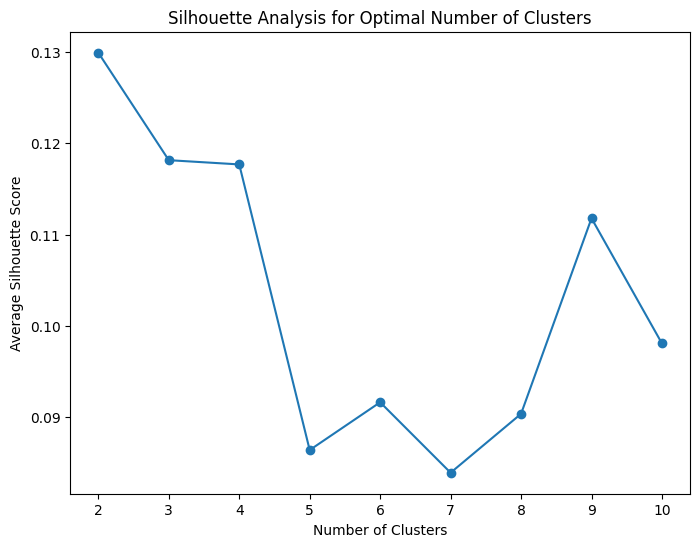

Optimal number of clusters: 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


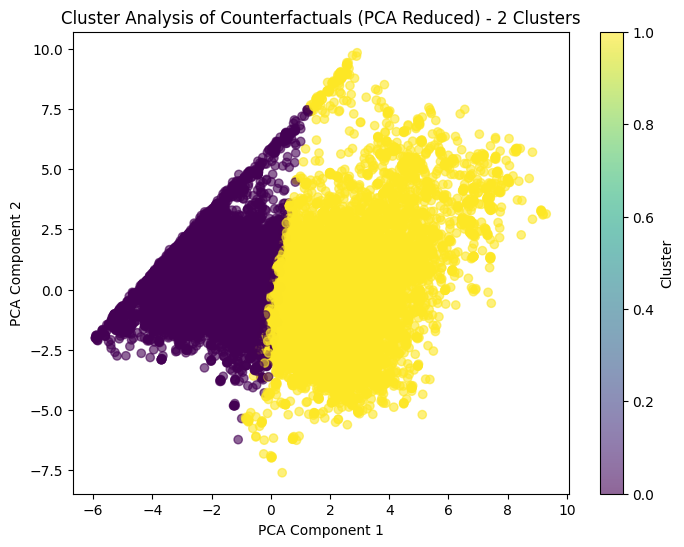

Cluster Feature Importance:
                 F         M     asian     black  hispanic    native     other   
Cluster                                                                         
0        0.434665  0.565484  0.039958  0.103994  0.045213  0.017198  0.043554  \
1        0.451350  0.545991  0.040453  0.106629  0.048540  0.020383  0.034645   

          unknown     white  sedative  ...  potassium_avg  resprate_mean   
Cluster                                ...                                 
0        0.113348  0.715290  0.033413  ...       1.664389       5.581523  \
1        0.120122  0.703766  0.099546  ...       2.369649      15.850784   

         sodium_avg  spo2_mean  sysbp_mean  uo_rt_12hr  uo_rt_24hr  uo_rt_6hr   
Cluster                                                                         
0         45.641621  27.533173   34.630013    1.892124   29.506071   0.470975  \
1         66.037926  77.237244   97.926872    2.660653   28.490215   1.752034   

          wbc_av

In [7]:
import dice_ml
from dice_ml.utils import helpers
from dice_ml import Dice
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load your trained model
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/logR_model(raw).h5')

# Ensure X_train, X_test, and other DataFrames are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')

# Prepare DiCE data object
X_train_with_label = X_train.copy()
X_train_with_label['aki_stage'] = y_train

data = dice_ml.Data(dataframe=X_train_with_label, continuous_features=feature_names, outcome_name='aki_stage')

# Prepare DiCE model object
dice_model = dice_ml.Model(model=model, backend="TF2")  # Specify TensorFlow 2 as the backend

# Create a DiCE explainer
explainer = Dice(data, dice_model)

# Store the feature change counts and sum of absolute differences
feature_change_counts = defaultdict(int)
feature_change_sums = defaultdict(float)

all_counterfactuals = []  # To store all selected counterfactuals for clustering

# Process the first 100 test points
for i in range(4000):
    max_feature_changes = 0
    selected_counterfactuals = None

    for run in range(3):
        # Generate counterfactuals
        query_instance_df = X_test.iloc[[i]]
        counterfactuals = explainer.generate_counterfactuals(query_instance_df, total_CFs=10, desired_class="opposite")
        counterfactuals_pd = counterfactuals.cf_examples_list[0].final_cfs_df

        # Ensure both DataFrames have the same columns (excluding the outcome variable)
        counterfactuals_pd = counterfactuals_pd[query_instance_df.columns]

        # Calculate feature changes
        feature_changes = (counterfactuals_pd != query_instance_df.values).sum(axis=1)
        total_changes = feature_changes.sum()

        # Select the run with the highest feature variability
        if total_changes > max_feature_changes:
            max_feature_changes = total_changes
            selected_counterfactuals = counterfactuals_pd.copy()

    # Append selected counterfactuals to the list for clustering
    all_counterfactuals.append(selected_counterfactuals)

    # Increment the feature counts and sum of absolute differences
    for feature in selected_counterfactuals.columns:
        differences = np.abs(selected_counterfactuals[feature] - query_instance_df[feature].values[0])
        feature_change_counts[feature] += (selected_counterfactuals[feature] != query_instance_df[feature].values[0]).sum()
        feature_change_sums[feature] += differences.sum()

# Convert the feature change counts and sums to DataFrames
feature_change_df = pd.DataFrame.from_dict(feature_change_counts, orient='index', columns=['Change Count']).sort_values(by='Change Count', ascending=False)
feature_change_sums_df = pd.DataFrame.from_dict(feature_change_sums, orient='index', columns=['Sum of Absolute Differences']).sort_values(by='Sum of Absolute Differences', ascending=False)

# Normalize the data for better visualization
feature_change_df['Change Count Normalized'] = feature_change_df['Change Count'] / feature_change_df['Change Count'].max()
feature_change_sums_df['Sum of Absolute Differences Normalized'] = feature_change_sums_df['Sum of Absolute Differences'] / feature_change_sums_df['Sum of Absolute Differences'].max()

# Merge the two DataFrames for combined visualization
combined_df = feature_change_df.join(feature_change_sums_df, how='inner')

# Save the results to a CSV
combined_df.to_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/feature_change_analysis_LogR.csv')

# Plot the normalized feature change counts
plt.figure(figsize=(10, 8))
plt.barh(combined_df.index, combined_df['Change Count Normalized'], color='blue', label='Normalized Change Count')
plt.barh(combined_df.index, combined_df['Sum of Absolute Differences Normalized'], color='orange', alpha=0.6, label='Normalized Sum of Absolute Differences')
plt.xlabel('Normalized Value')
plt.title('Feature Change Analysis in Counterfactual Explanations')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Combine all counterfactuals into a single DataFrame for clustering
all_counterfactuals_df = pd.concat(all_counterfactuals)

# Normalize the data for clustering
scaler = StandardScaler()
all_counterfactuals_scaled = scaler.fit_transform(all_counterfactuals_df)

# Optional: Reduce dimensions using PCA for better visualization
pca = PCA(n_components=2)
all_counterfactuals_pca = pca.fit_transform(all_counterfactuals_scaled)

# Perform Silhouette Analysis to determine the optimal number of clusters
silhouette_scores = []
range_n_clusters = list(range(2, 11))  # Testing cluster sizes from 2 to 10

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_counterfactuals_scaled)
    silhouette_avg = silhouette_score(all_counterfactuals_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.show()

# Choose the optimal number of clusters based on the highest silhouette score
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_counterfactuals_scaled)

# Add the cluster labels to the DataFrame
all_counterfactuals_df['Cluster'] = cluster_labels

# Visualize the clusters (using PCA for 2D visualization)
plt.figure(figsize=(8, 6))
plt.scatter(all_counterfactuals_pca[:, 0], all_counterfactuals_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.title(f'Cluster Analysis of Counterfactuals (PCA Reduced) - {optimal_n_clusters} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Save the clustered counterfactuals to a CSV
all_counterfactuals_df.to_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/clustered_counterfactuals_LogR.csv')

# Further Analysis: Review the feature importance within each cluster
cluster_feature_importance = all_counterfactuals_df.groupby('Cluster').mean()
print("Cluster Feature Importance:\n", cluster_feature_importance)


# Normalized

In [ ]:
import pandas as pd
# Load the variables from the CSV files for modeling
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_train-final.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_test-final.csv')
X_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_validation-final.csv')

y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_train-final.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_test-final.csv')
y_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_validation-final.csv')

print("X and y variables loaded from CSV files.")

# Check that the loaded data matches the original
print(f"Loaded X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Loaded X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Loaded X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}")

X and y variables loaded from CSV files.
Loaded X_train shape: (37802, 32), y_train shape: (37802, 1)
Loaded X_test shape: (4724, 32), y_test shape: (4724, 1)
Loaded X_validation shape: (4724, 32), y_validation shape: (4724, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import time

# Ensure that X_train, X_test, X_validation are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')

# Ensure that y_train, y_test, y_validation are float32 or int32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_validation = y_validation.astype('float32')

# Define the Logistic Regression model using TensorFlow
model_final = models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model_final.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary crossentropy for binary classification
              metrics=['accuracy'])

# Measure the time taken for model fitting
start_time = time.time()

# Train the model
history = model_final.fit(X_train, y_train,
                    epochs=150,  # You can adjust the number of epochs
                    validation_data=(X_validation, y_validation),
                    batch_size=32)  # Adjust batch size as needed

end_time = time.time()
print(f"Time taken to train the model: {end_time - start_time:.2f} seconds")

# Evaluate the model on the test set
test_loss, test_accuracy = model_final.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
model_final.save('/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/logR_model(norm).h5')
print("Model saved as 'final/logistic_regression_model(norm).h5'.")

# Make predictions
y_pred_prob_fin = model_final.predict(X_test)
y_pred_fin = (y_pred_prob_fin > 0.5).astype(int)  # Convert probabilities to binary output (0 or 1)


Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6874 - loss: 0.6056 - val_accuracy: 0.7650 - val_loss: 0.5358
Epoch 2/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7646 - loss: 0.5316 - val_accuracy: 0.7667 - val_loss: 0.5152
Epoch 3/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7689 - loss: 0.5158 - val_accuracy: 0.7691 - val_loss: 0.5056
Epoch 4/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7699 - loss: 0.5077 - val_accuracy: 0.7707 - val_loss: 0.5011
Epoch 5/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7728 - loss: 0.5044 - val_accuracy: 0.7720 - val_loss: 0.4990
Epoch 6/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7752 - loss: 0.4996 - val_accuracy: 0.7735 - val_loss: 0.4967
Epoch 7/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7702 - loss: 0.5024 - val_accuracy: 0.7731 - val_loss: 0.4958
Epoch 8/150
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7752 - loss: 0.4956 - val_

Test Accuracy: 0.7854
Model saved as 'final/logistic_regression_model(norm).h5'.
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


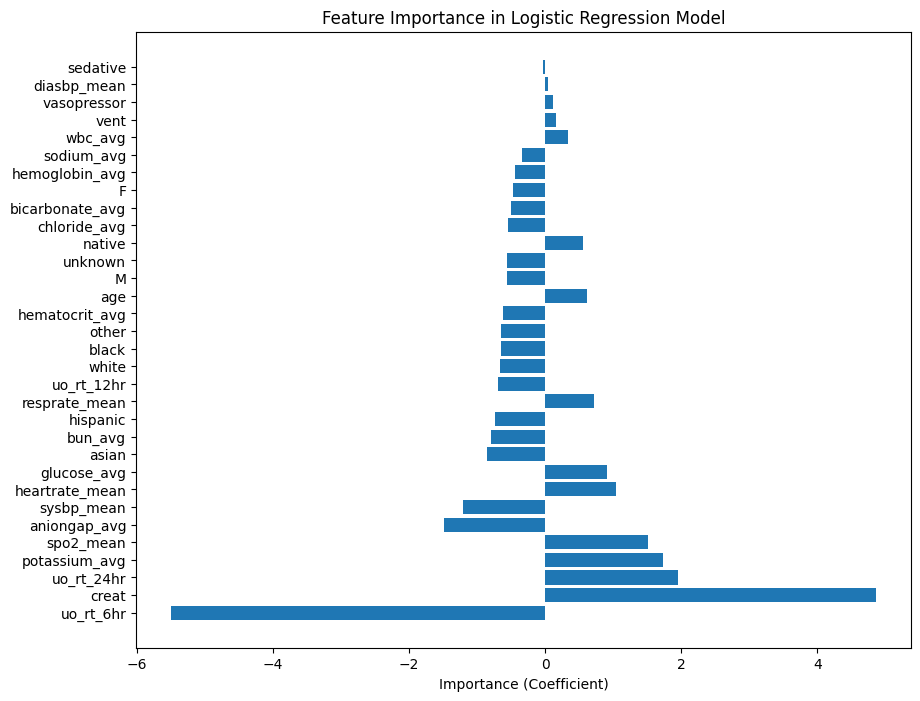

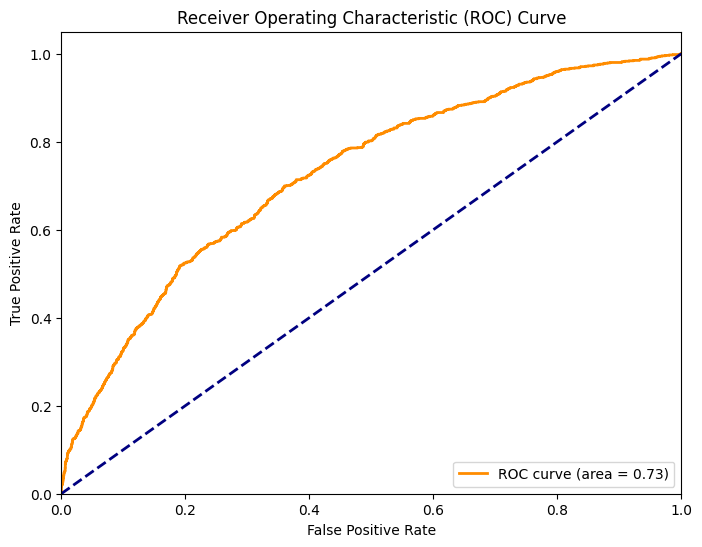

Area Under ROC Curve: 0.73
Brier score : 0.474
F1 score : 0.47
95% Confidence interval for F1 score: [0.45, 0.50]


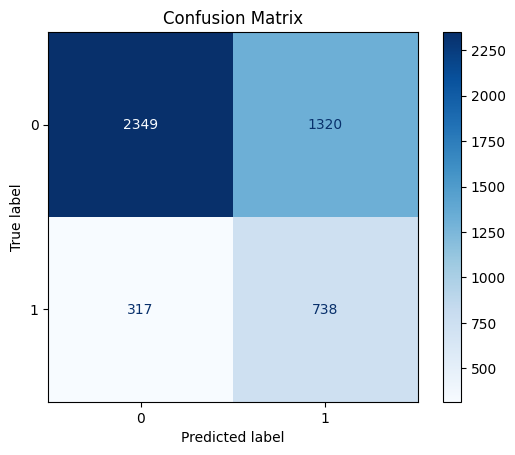

In [ ]:
# Evaluate performance using the previously defined function
evaluate_logistic_regression_performance(model_final, X_test, y_test, y_pred_prob_fin, feature_names)

In [ ]:
# Select a specific instance from X_test (e.g., the first instance)
instance_index = 0  # Change this to select a different instance

# Create a query instance by using .iloc to correctly index into the DataFrame
query_instance = {feature_names[i]: X_test.iloc[instance_index, i] for i in range(len(feature_names))}

# Verify the query_instance structure
print(query_instance)

{'F': 0.0, 'M': 1.0, 'asian': 0.0, 'black': 0.0, 'hispanic': 0.0, 'native': 0.0, 'other': 0.0, 'unknown': 0.0, 'white': 1.0, 'sedative': 0.0, 'vasopressor': 0.0, 'vent': 0.0, 'aniongap_avg': 0.17773306, 'bicarbonate_avg': 0.21448693, 'bun_avg': 0.031615224, 'chloride_avg': 0.26796988, 'creat': 0.03326858, 'diasbp_mean': 0.24279092, 'glucose_avg': 0.20036829, 'heartrate_mean': 0.23071739, 'hematocrit_avg': 0.21581538, 'hemoglobin_avg': 0.1807847, 'potassium_avg': 0.20970266, 'resprate_mean': 0.23989119, 'sodium_avg': 0.27835935, 'spo2_mean': 0.3281675, 'sysbp_mean': 0.22176257, 'uo_rt_12hr': 0.11084702, 'uo_rt_24hr': 0.11953823, 'uo_rt_6hr': 0.09546788, 'wbc_avg': 0.15037616, 'age': 0.38118532}


In [ ]:
import pandas as pd
# Load the variables from the CSV files for modeling
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_train-final.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_test-final.csv')
X_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_validation-final.csv')

y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_train-final.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_test-final.csv')
y_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_validation-final.csv')

print("X and y variables loaded from CSV files.")

# Check that the loaded data matches the original
print(f"Loaded X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Loaded X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Loaded X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}")

X and y variables loaded from CSV files.
Loaded X_train shape: (37802, 32), y_train shape: (37802, 1)
Loaded X_test shape: (4724, 32), y_test shape: (4724, 1)
Loaded X_validation shape: (4724, 32), y_validation shape: (4724, 1)


In [ ]:
import dice_ml
from dice_ml.utils import helpers
from dice_ml import Dice
import tensorflow as tf

# Ensure that X_train, X_test, X_validation are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')

# Ensure that y_train, y_test, y_validation are float32 or int32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_validation = y_validation.astype('float32')

# Load your trained model
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/logR_model(final).h5')

# Re-attach the 'aki_stage' to the DataFrame before creating the DiCE data object
X_train_with_label = X_train.copy()
X_train_with_label['aki_stage'] = y_train

# Prepare DiCE data object
data = dice_ml.Data(dataframe=X_train_with_label, continuous_features=feature_names, outcome_name='aki_stage')

# Prepare DiCE model object
dice_model = dice_ml.Model(model=model_final, backend="TF2")  # Specify TensorFlow 2 as the backend

# Create a DiCE explainer
explainer = Dice(data, dice_model)

# Select a specific instance from X_test (e.g., the first instance)
instance_index = 0  # Change this to select a different instance

# Create a query instance as a DataFrame (single row)
query_instance_df = X_test.iloc[[instance_index]]

In [ ]:
# Generate counterfactual explanations
counterfactuals = explainer.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")
# Visualize the generated counterfactuals
counterfactuals.visualize_as_dataframe(show_only_changes=True)


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.86753174' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and 

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.239891,0.278359,0.328167,0.221763,0.110847,0.119538,0.095468,0.150376,0.381185,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,0.10000000149011612,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,0.5,-,-,-,-,-,1.0


In [ ]:
counterfactuals_pd = counterfactuals.cf_examples_list[0].final_cfs_df
# Option 2: If you want to see the entire table without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(counterfactuals_pd)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.2       0.0  \
1  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
2  0.0  1.0   0.0    0.0      0.0      0.0    0.0     1.0     1.0      0.0        0.0       0.0   
3  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
4  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   

   aniongap_avg  bicarbonate_avg   bun_avg  chloride_avg    creat   diasbp_mean  glucose_avg   
0    0.177733       0.214487      0.031615     0.26797    0.769607   0.242791     0.200368    \
1    0.177733       0.214487      0.031615     0.26797    0.942790   0.800000     0.200368     
2    0.177733       0.214487      0.031615     0.26797    0.900633   0.242791     0.200368     
3    0.177733       0

In [ ]:
cf_desired = explainer.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite", proximity_weight=1.5, diversity_weight=1.5)
cf_desired.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will ra

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.239891,0.278359,0.328167,0.221763,0.110847,0.119538,0.095468,0.150376,0.381185,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,0.0,-,-,1.0
1,-,-,-,-,1.100000023841858,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,-,-,0.6000000238418579,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0


In [ ]:
cf_desired_pd = cf_desired.cf_examples_list[0].final_cfs_df
# Option 2: If you want to see the entire table without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(cf_desired_pd)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0  \
1  0.0  1.0   0.0    0.0      1.1      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
2  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
3  0.0  1.0   0.0    0.0      0.0      0.0    0.6     0.0     1.0      0.0        0.0       0.0   
4  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     0.8      0.0        0.0       0.0   

   aniongap_avg  bicarbonate_avg   bun_avg  chloride_avg    creat   diasbp_mean  glucose_avg   
0    0.177733       0.214487      0.031615     0.26797    0.607454   0.242791     0.200368    \
1    0.177733       0.214487      0.031615     0.26797    0.649282   0.242791     0.200368     
2    0.177733       0.214487      0.031615     0.26797    0.480938   0.242791     0.200368     
3    0.177733       0

In [ ]:
instance_index = 99  # Change this to select a different instance

# Create a query instance as a DataFrame (single row)
query_instance_df = X_test.iloc[[instance_index]]

In [ ]:
cf_desired_factor = explainer.generate_counterfactuals(query_instance_df, total_CFs=16, desired_class="opposite" )
cf_desired_factor.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will ra

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.501068,0.636261,0.79875,0.503089,0.264565,0.263809,0.30506,0.300535,0.655226,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
3,-,-,0.800000011920929,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
5,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
6,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,0.20000000298023224,1.0
7,-,-,-,-,2.7755575615628914e-17,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
8,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
9,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0


In [ ]:
# Access the counterfactual examples as a pandas DataFrame
cf_desired_factor_pd = cf_desired_factor.cf_examples_list[0].final_cfs_df

In [ ]:
# Option 2: If you want to see the entire table without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(cf_desired_factor_pd)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

     F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0  \
1   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
2   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
3   0.0  1.0   0.8    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
4   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
5   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
6   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
7   0.0  1.0   0.0    0.0      0.5      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
8   0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   


#RF

In [ ]:
!pip install tensorflow_decision_forests

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: tensorflow
    Found exis

In [ ]:
import tensorflow_decision_forests as tfdf

print("TensorFlow Decision Forests version:", tfdf.__version__)

TensorFlow Decision Forests version: 1.9.2


In [ ]:
import pandas as pd
# Load the variables from the CSV files for modeling
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_train-raw.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_test-raw.csv')
X_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_validation-raw.csv')

y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_train-raw.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_test-raw.csv')
y_validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_validation-raw.csv')

print("X and y variables loaded from CSV files.")

# Check that the loaded data matches the original
print(f"Loaded X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Loaded X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Loaded X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}")

X and y variables loaded from CSV files.
Loaded X_train shape: (37802, 32), y_train shape: (37802, 1)
Loaded X_test shape: (4724, 32), y_test shape: (4724, 1)
Loaded X_validation shape: (4724, 32), y_validation shape: (4724, 1)


In [ ]:
# Extract column names from X_train
feature_names = X_train.columns.tolist()

In [ ]:
print(feature_names)

['F', 'M', 'asian', 'black', 'hispanic', 'native', 'other', 'unknown', 'white', 'sedative', 'vasopressor', 'vent', 'aniongap_avg', 'bicarbonate_avg', 'bun_avg', 'chloride_avg', 'creat', 'diasbp_mean', 'glucose_avg', 'heartrate_mean', 'hematocrit_avg', 'hemoglobin_avg', 'potassium_avg', 'resprate_mean', 'sodium_avg', 'spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr', 'wbc_avg', 'age']


In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import time

# Ensure that X_train, X_test, X_validation are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')

# Ensure that y_train, y_test, y_validation are float32 or int32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_validation = y_validation.astype('float32')

# Concatenate X and y for both train and test datasets to create a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Convert the pandas DataFrame to a TensorFlow Dataset
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label="aki_stage")
test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label="aki_stage")

# Define the Random Forest model using TensorFlow Decision Forests
rf_model = tfdf.keras.RandomForestModel(
    num_trees=700,          # Number of trees in the forest
    max_depth=40,           # Maximum depth of each tree
    min_examples=2,         # Minimum number of examples per leaf
    random_seed=42          # Random seed for reproducibility
)

start_time = time.time()
# Train the model
rf_model.fit(train_dataset)
end_time = time.time()
print(f"Time taken to train the RF model: {end_time - start_time:.2f} seconds")

# Save the model in the native Keras format
rf_model.save('/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/RF_model(raw).keras')
print("Model saved as 'final/RF_model(raw).keras'.")

# Evaluate the model on the test set
evaluation = rf_model.evaluate(test_dataset, return_dict=True)

# If accuracy is not in evaluation, calculate it manually
if 'accuracy' not in evaluation:
    # Manually calculate accuracy
    y_pred = np.argmax(rf_model.predict(test_dataset), axis=1)
    y_true = test_data['aki_stage'].values
    accuracy = np.mean(y_pred == y_true)
    print(f"Test Accuracy (calculated manually): {accuracy:.4f}")
else:
    print(f"Test Accuracy: {evaluation['accuracy']:.4f}")

# Optionally, include a validation step
if X_validation is not None and y_validation is not None:
    validation_data = pd.concat([X_validation, y_validation], axis=1)
    validation_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(validation_data, label="aki_stage")

    # Evaluate the model on the validation set
    validation_evaluation = rf_model.evaluate(validation_dataset, return_dict=True)

    # Manually calculate validation accuracy if it's not provided
    y_val_pred = np.argmax(rf_model.predict(validation_dataset), axis=1)
    y_val_true = validation_data['aki_stage'].values
    val_accuracy = np.mean(y_val_pred == y_val_true)
    print(f"Validation Accuracy (calculated manually): {val_accuracy:.4f}")

# Make predictions on the test set
predictions_rf = rf_model.predict(test_dataset)
y_pred_rf = np.argmax(predictions_rf, axis=1)  # Convert probabilities to binary output (0 or 1)


Use /tmp/tmpfqcuqdl8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:07.098627. Found 37802 examples.
Training model...
Model trained in 0:01:14.314956
Compiling model...
Model compiled.
Time taken to train the RF model: 83.28 seconds
Model saved as 'final/RF_model(raw).keras'.
5/5 [==============================] - 2s 322ms/step
Test Accuracy (calculated manually): 0.7767
5/5 [==============================] - 2s 305ms/step
Validation Accuracy (calculated manually): 0.7648
5/5 [==============================] - 2s 299ms/step


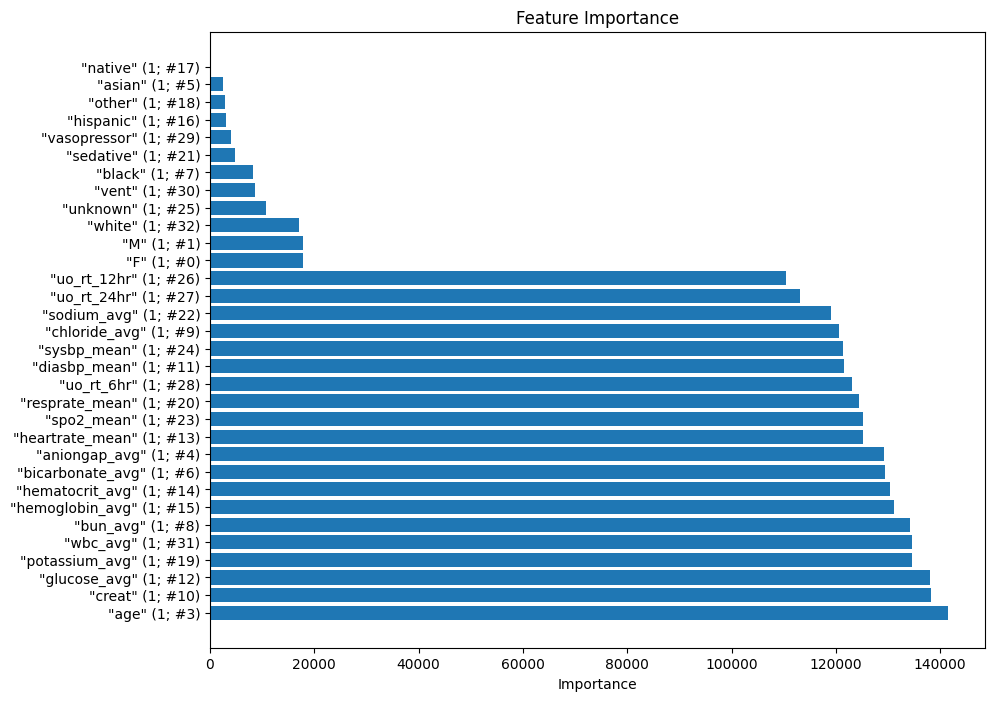

5/5 [==============================] - 2s 304ms/step
Shape of y_prob: (4724, 1)
First few predictions: [[0.08142859]
 [0.10428578]
 [0.08428574]
 [0.37428632]
 [0.19428596]]


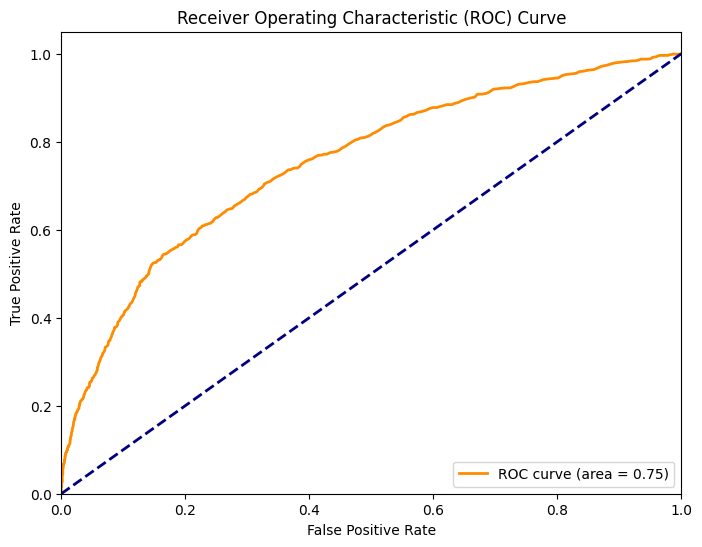

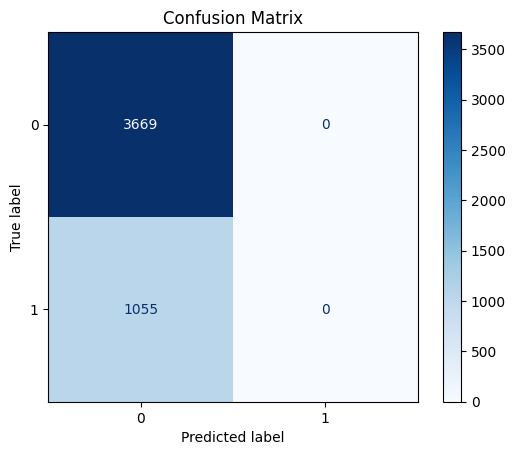

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import time

# Assuming train_dataset, test_dataset, rf_model are already defined and trained

# Step 1: Feature Importance
# Extract and visualize feature importance
top_features_rf = rf_model.make_inspector().variable_importances()["NUM_NODES"]

# Extract feature names and their corresponding importance values
feature_names_rf = [str(feature[0]) for feature in top_features_rf]
importances_rf = [feature[1] for feature in top_features_rf]

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_names_rf, importances_rf)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

# Step 2: Visualize Model Performance

# Predict probabilities on the test set
y_prob_rf = rf_model.predict(test_dataset)
y_true_rf = test_data['aki_stage'].values

# Check the shape of y_prob
print(f"Shape of y_prob: {y_prob_rf.shape}")

# Check the first few elements of y_prob
print(f"First few predictions: {y_prob_rf[:5]}")

# ROC Curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true_rf, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm_rf = confusion_matrix(y_true_rf, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])

disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Area Under ROC Curve: 0.75
Brier Score: 0.145
F1 Score: 0.00
95% Confidence Interval for F1 Score: [0.00, 0.00]


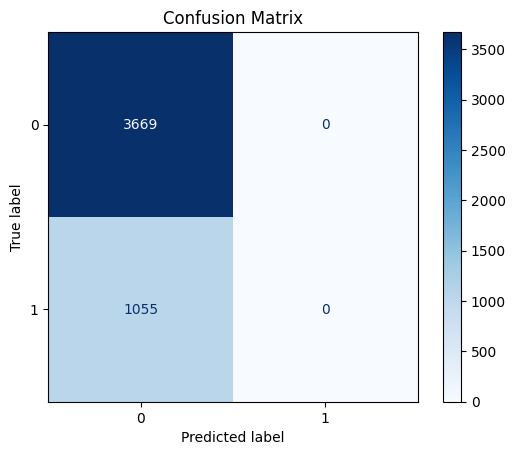

In [ ]:
from sklearn.metrics import roc_curve, auc, brier_score_loss, f1_score, precision_recall_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_performance(y_true, y_pred_prob, y_pred, n_bootstraps=1000, alpha=0.95):
    """
    Evaluate the performance of a model, including ROC AUC, Brier Score, F1 Score, and 95% Confidence Interval for F1 Score.

    Parameters:
    - y_true: True labels.
    - y_pred_prob: Predicted probabilities for the positive class.
    - y_pred: Predicted class labels.
    - n_bootstraps: Number of bootstraps for confidence interval calculation.
    - alpha: Confidence level for F1 score confidence intervals.
    """

    # Calculate Area Under ROC Curve
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    # Calculate Brier Score
    brier = brier_score_loss(y_true, y_pred_prob)

    # Calculate F1 Score
    f1 = f1_score(y_true, y_pred)

    # Calculate 95% Confidence Interval for F1 Score
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = resample(np.arange(len(y_pred)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = f1_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower = sorted_scores[int((1.0-alpha)/2.0 * len(sorted_scores))]
    upper = sorted_scores[int((alpha+(1.0-alpha)/2.0) * len(sorted_scores))]

    # Display metrics
    print(f"Area Under ROC Curve: {roc_auc:.2f}")
    print(f"Brier Score: {brier:.3f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"95% Confidence Interval for F1 Score: [{lower:.2f}, {upper:.2f}]")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Convert predictions to NumPy arrays if they are not already
y_test_array = np.array(y_test)
predictions_rf_array = np.array(predictions_rf).flatten()
y_pred_rf_array = np.array(y_pred_rf)

# Call the evaluation function
evaluate_model_performance(y_test_array, predictions_rf_array, y_pred_rf_array)

In [ ]:
import dice_ml
from dice_ml import Dice
import tensorflow as tf
import pandas as pd


class WrappedTFDFModel:
    def __init__(self, tfdf_model, feature_names):
        self.model = tfdf_model
        self.feature_names = feature_names

    def __call__(self, x, **kwargs):
        return self.predict(x)

    def predict(self, x):
        # Convert the input array into a dictionary
        if isinstance(x, pd.DataFrame):
            input_dict = {col: tf.convert_to_tensor(x[col].values) for col in self.feature_names}
        else:
            input_dict = {col: tf.convert_to_tensor(x[:, i]) for i, col in enumerate(self.feature_names)}
        predictions = self.model(input_dict)
        return predictions


# Assuming X_train, X_test, y_train, y_test, and rf_model are already defined
# Ensure that X_train, X_test, X_validation are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')

# Ensure that y_train, y_test, y_validation are float32 or int32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_validation = y_validation.astype('float32')

# Re-attach the 'aki_stage' to the DataFrame
X_train_with_label = X_train.copy()
X_train_with_label['aki_stage'] = y_train

X_test_with_label = X_test.copy()
X_test_with_label['aki_stage'] = y_test

# Prepare DiCE data object with original feature names
data = dice_ml.Data(dataframe=X_train_with_label, continuous_features=list(X_train.columns), outcome_name='aki_stage')

# Wrap the TFDF model
wrapped_model = WrappedTFDFModel(rf_model, feature_names=list(X_train.columns))

# Prepare DiCE model object using the wrapped TFDF model
dice_model = dice_ml.Model(model=wrapped_model, backend="TF2")

# Create a DiCE explainer with the original data and model
explainer = Dice(data, dice_model)

# Select a specific instance from X_test (e.g., the 36th instance)
instance_index = 0  # Change this to select a different instance
query_instance_df = X_test.iloc[[instance_index]]

# Generate counterfactual explanations using the original model and data
counterfactuals = explainer.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")

# Print the counterfactuals if generated
if counterfactuals.cf_examples_list[0].final_cfs_df is not None:
    print(counterfactuals.cf_examples_list[0].final_cfs_df)
else:
    print("No Counterfactuals found for the given configuration.")


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28.7' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.2' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will r

     F    M  asian  black  hispanic  native  other  unknown  white  sedative   
0  0.0  1.0    0.0    0.0       0.0     0.0    0.0      0.0    1.0       0.9  \
1  0.0  0.1    0.0    0.0       0.0     0.7    0.0      0.0    1.0       0.0   
2  0.0  1.0    0.0    0.0       0.0     0.0    0.0      0.0    1.0       0.0   
3  0.0  1.0    0.0    0.0       0.0     0.0    0.0      0.0    1.0       0.0   
4  0.0  1.0    0.0    0.0       0.0     0.0    0.0      0.0    1.0       0.9   

   ...  resprate_mean  sodium_avg   spo2_mean  sysbp_mean  uo_rt_12hr   
0  ...      33.599998   41.197182   32.816750   36.886509    0.483377  \
1  ...      23.600000   41.197182  100.099998   81.000000    0.483377   
2  ...       7.648980   41.197182   86.099998   36.886509    0.483377   
3  ...       7.648980   41.197182   86.099998   36.886509    0.483377   
4  ...      33.599998   41.197182   32.816750   36.886509    0.483377   

   uo_rt_24hr  uo_rt_6hr    wbc_avg        age  aki_stage  
0    0.491434   0.48

'/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/RF_model(raw).keras'

In [ ]:
counterfactuals.visualize_as_dataframe(show_only_changes=True)
# Access the counterfactual examples as a pandas DataFrame
counterfactuals_df = counterfactuals.cf_examples_list[0].final_cfs_df

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(counterfactuals_df)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.64898,41.197182,32.81675,36.886509,0.483377,0.491434,0.485316,4.369718,48.296272,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,-,-,-,-,-,0.8999999761581421,...,33.599998474121094,-,-,-,-,-,-,89.9000015258789,-,1.0
1,-,0.10000000149011612,-,-,-,0.699999988079071,-,-,-,-,...,23.600000381469727,-,100.0999984741211,81.0,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,...,-,-,86.0999984741211,-,-,-,-,-,86.5,1.0
3,-,-,-,-,-,-,-,-,-,-,...,-,-,86.0999984741211,-,-,-,-,-,86.5,1.0
4,-,-,-,-,-,-,-,-,-,0.8999999761581421,...,33.599998474121094,-,-,-,-,-,-,89.9000015258789,-,1.0


    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.9        0.0       0.0  \
1  0.0  0.1   0.0    0.0      0.0      0.7    0.0     0.0     1.0      0.0        0.2       0.0   
2  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       1.0   
3  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       1.0   
4  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.9        0.0       0.0   

   aniongap_avg  bicarbonate_avg    bun_avg   chloride_avg    creat    diasbp_mean  glucose_avg   
0    21.700001      7.507042      193.300003    31.084507    7.200000   21.446531    496.899994  \
1    36.599998      4.100000        2.971831    31.084507    0.192958   21.446531     56.704224   
2    30.000000      7.507042        2.971831    31.084507   14.200000   21.446531   5231.899902   
3     3.7

In [ ]:
# Generate counterfactuals with custom proximity and diversity weights
cf_desired_standardized = explainer.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite", proximity_weight=0.5, diversity_weight=0.5 )
# Access the counterfactual examples as a pandas DataFrame
cf_desired_standardized_df = cf_desired_standardized.cf_examples_list[0].final_cfs_df
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(cf_desired_standardized_df)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '128.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will 

    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.0    0.5      0.0      0.6    0.0     0.0     0.1      0.0        0.0       0.0  \
1  0.0  1.0   0.0    0.5      0.0      0.6    0.0     0.0     0.1      0.0        0.0       0.6   
2  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       1.1   
3  0.0  1.0   0.0    0.5      0.0      0.0    0.0     0.0     0.1      0.0        0.0       0.0   
4  0.0  1.0   0.0    0.5      0.0      0.6    0.0     0.0     0.1      0.0        0.0       0.6   

   aniongap_avg  bicarbonate_avg   bun_avg  chloride_avg  creat  diasbp_mean  glucose_avg   
0    3.732394        7.507042     2.971831    28.400000   13.6   102.400002    419.399994  \
1    3.732394        7.507042     2.971831    28.400000   13.6   102.400002    419.399994   
2    3.732394        7.507042     2.971831    31.084507    2.8    31.700001   1817.900024   
3    3.732394        7.507042    

In [ ]:
# Attempt to generate counterfactuals with fewer constraints
cf_desired_factor_standardized = explainer.generate_counterfactuals(query_instance_df,total_CFs=10, desired_class="opposite", features_to_vary='all', proximity_weight=0.1, diversity_weight=0.1)

# Visualize the counterfactuals as a dataframe, showing only the changes
cf_desired_factor_standardized.visualize_as_dataframe(show_only_changes=True)
# Access the counterfactual examples as a pandas DataFrame
cf_desired_factor_standardized_df = cf_desired_factor_standardized.cf_examples_list[0].final_cfs_df

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(cf_desired_factor_standardized_df)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '45.4' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will r

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.64898,41.197182,32.81675,36.886509,0.483377,0.491434,0.485316,4.369718,48.296272,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,1.0,-,1.0,-,0.20000000298023224,-,...,25.399999618530273,-,-,-,-,-,-,214.89999389648438,-,1.0
1,-,-,2.7755575615628914e-17,-,0.699999988079071,-,2.7755575615628914e-17,-,-,-,...,-,116.80000305175781,86.0,66.9000015258789,-,-,-,276.1000061035156,-,1.0
2,-,-,-,-,1.0,-,1.0,-,0.20000000298023224,-,...,25.399999618530273,-,-,-,-,-,-,214.89999389648438,-,1.0
3,-,-,-,-,1.0,-,1.0,-,0.20000000298023224,-,...,25.399999618530273,-,-,-,-,-,-,214.89999389648438,-,1.0
4,-,-,-,-,0.699999988079071,-,2.7755575615628914e-17,-,-,-,...,-,116.80000305175781,86.0,66.9000015258789,-,-,-,276.1000061035156,-,1.0
5,-,-,-,1.0,-,-,-,-,-,2.7755575615628914e-17,...,22.799999237060547,12.899999618530273,63.20000076293945,-,-,14.5,-,8.899999618530273,60.0,1.0
6,-,0.30000001192092896,-,0.699999988079071,2.7755575615628914e-17,-,-2.7755575615628914e-17,-,-,-,...,-,154.6999969482422,94.0999984741211,-,-,-,-,132.39999389648438,-,1.0
7,-,-,-,1.0,-,-,-,-,-,0.5,...,22.799999237060547,12.899999618530273,63.20000076293945,-,-,14.5,-,8.899999618530273,60.0,1.0
8,-,-,-,-,1.0,-,-,-,-,-,...,18.100000381469727,-,-,168.39999389648438,-,30.899999618530273,-,-,76.80000305175781,1.0
9,-,-,-,-,-,-,-,-2.7755575615628914e-17,-,-,...,-,-,82.0,-,-,-,-,-,-,1.0


    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.0    0.0      1.0      0.0    1.0     0.0     0.2      0.0        0.0       0.9  \
1  0.0  1.0   0.5    0.0      0.7      0.0    0.4     0.0     1.0      0.0        0.3       0.5   
2  0.0  1.0   0.0    0.0      1.0      0.0    1.0     0.0     0.2      0.0        0.0       0.9   
3  0.0  1.0   0.0    0.0      1.0      0.0    1.0     0.0     0.2      0.0        0.0       0.0   
4  0.0  1.0   0.0    0.0      0.7      0.0    0.4     0.0     1.0      0.0        0.3       0.5   
5  0.0  1.0   0.0    1.0      0.0      0.0    0.0     0.0     1.0      0.5        0.0       0.8   
6  0.0  0.3   0.0    0.7      0.5      0.0    0.3     0.2     1.0      0.0        0.7       0.7   
7  0.0  1.0   0.0    1.0      0.0      0.0    0.0     0.0     1.0      0.5        0.0       0.8   
8  0.0  1.0   0.0    0.0      1.0      0.0    0.0     0.0     0.9      0.1        0.0       0.5   
9  0.0  1.

# Normalized

In [ ]:
import pandas as pd
# Load the variables from the CSV files for modeling
X_train_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_train-final.csv')
X_test_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_test-final.csv')
X_validation_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/X_validation-final.csv')

y_train_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_train-final.csv')
y_test_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_test-final.csv')
y_validation_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AKI/final/input_data/y_validation-final.csv')

print("X and y variables loaded from CSV files.")

# Check that the loaded data matches the original
print(f"Loaded X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Loaded X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Loaded X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}")

X and y variables loaded from CSV files.
Loaded X_train shape: (37802, 32), y_train shape: (37802, 1)
Loaded X_test shape: (4724, 32), y_test shape: (4724, 1)
Loaded X_validation shape: (4724, 32), y_validation shape: (4724, 1)


In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import time

# Concatenate X and y for both train and test datasets to create a single DataFrame
train_data_final = pd.concat([X_train_final, y_train_final], axis=1)
test_data_final = pd.concat([X_test_final, y_test_final], axis=1)

# Convert the pandas DataFrame to a TensorFlow Dataset
train_dataset_final = tfdf.keras.pd_dataframe_to_tf_dataset(train_data_final, label="aki_stage")
test_dataset_final = tfdf.keras.pd_dataframe_to_tf_dataset(test_data_final, label="aki_stage")

# Define the Random Forest model using TensorFlow Decision Forests
rf_model_final = tfdf.keras.RandomForestModel(
    num_trees=700,          # Number of trees in the forest
    max_depth=40,           # Maximum depth of each tree
    min_examples=2,         # Minimum number of examples per leaf
    random_seed=42          # Random seed for reproducibility
)

start_time_final = time.time()
# Train the model
rf_model_final.fit(train_dataset_final)
end_time_final = time.time()
print(f"Time taken to train the RF model: {end_time_final - start_time_final:.2f} seconds")

# Save the model in the native Keras format
rf_model_final.save('/content/drive/MyDrive/Colab Notebooks/AKI/final/final_models/RF_model(final).keras')
print("Model saved as 'final/RF_model(final).keras'.")

# Evaluate the model on the test set
evaluation_final = rf_model_final.evaluate(test_dataset_final, return_dict=True)

# If accuracy is not in evaluation, calculate it manually
if 'accuracy' not in evaluation_final:
    # Manually calculate accuracy
    y_pred_final = np.argmax(rf_model_final.predict(test_dataset_final), axis=1)
    y_true_final = test_data_final['aki_stage'].values
    accuracy_final = np.mean(y_pred_final == y_true_final)
    print(f"Test Accuracy (calculated manually): {accuracy_final:.4f}")
else:
    print(f"Test Accuracy: {evaluation_final['accuracy']:.4f}")

# Optionally, include a validation step
if X_validation_final is not None and y_validation_final is not None:
    validation_data_final = pd.concat([X_validation_final, y_validation_final], axis=1)
    validation_dataset_final = tfdf.keras.pd_dataframe_to_tf_dataset(validation_data_final, label="aki_stage")

    # Evaluate the model on the validation set
    validation_evaluation_final = rf_model_final.evaluate(validation_dataset_final, return_dict=True)

    # Manually calculate validation accuracy if it's not provided
    y_val_pred_final = np.argmax(rf_model_final.predict(validation_dataset_final), axis=1)
    y_val_true_final = validation_data_final['aki_stage'].values
    val_accuracy_final = np.mean(y_val_pred_final == y_val_true_final)
    print(f"Validation Accuracy (calculated manually): {val_accuracy_final:.4f}")

# Make predictions on the test set
predictions_rf_final = rf_model_final.predict(test_dataset_final)
y_pred_rf_final = np.argmax(predictions_rf_final, axis=1)  # Convert probabilities to binary output (0 or 1)
# Ensure y_pred_prob is the correct shape (1D array of probabilities)
y_prob_rf_final = predictions_rf_final.flatten()


Use /tmp/tmprh85ycw4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.493333. Found 37802 examples.
Training model...
Model trained in 0:01:04.483138
Compiling model...
Model compiled.
Time taken to train the RF model: 67.26 seconds
Model saved as 'final/RF_model(final).keras'.
5/5 [==============================] - 2s 317ms/step
Test Accuracy (calculated manually): 0.7767
5/5 [==============================] - 2s 316ms/step
Validation Accuracy (calculated manually): 0.7648
5/5 [==============================] - 2s 319ms/step


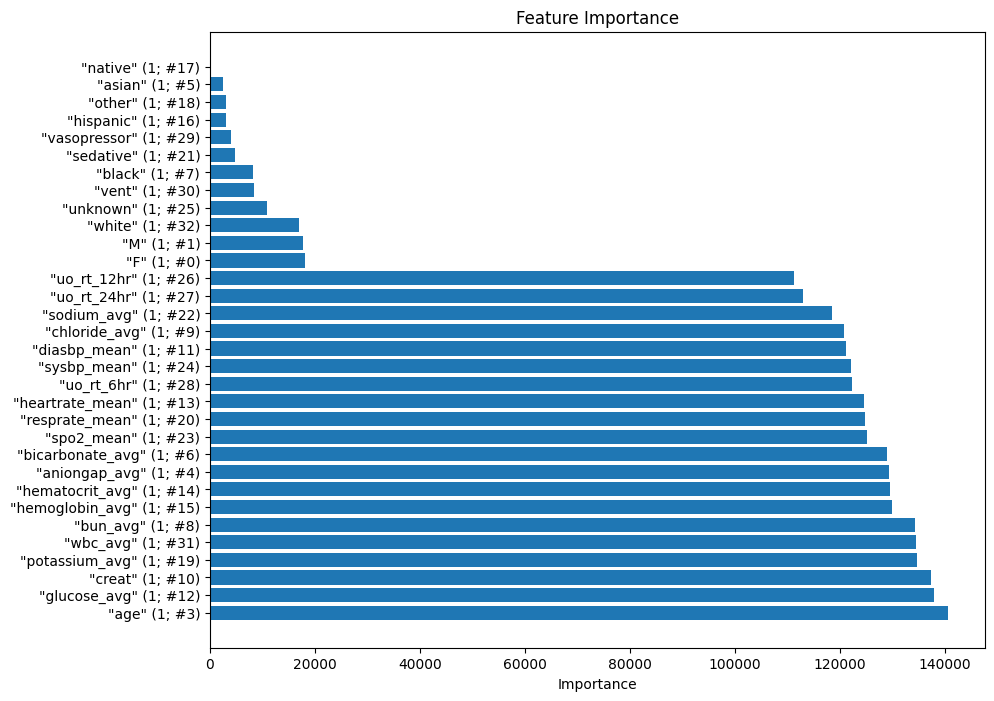

5/5 [==============================] - 1s 104ms/step
Shape of y_prob: (4724, 1)
First few predictions: [[0.27142897]
 [0.6842831 ]
 [0.28428614]
 [0.31857193]
 [0.28428614]]


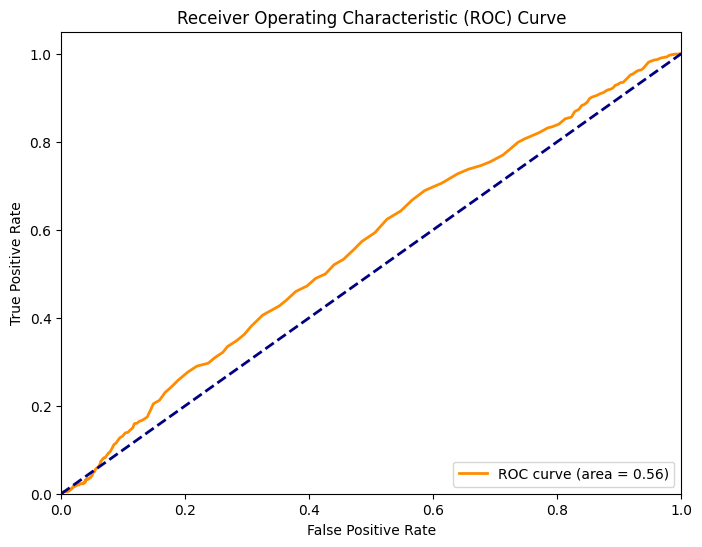

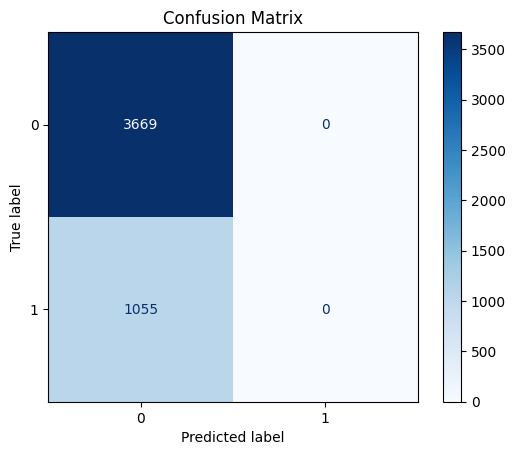

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import time

# Assuming train_dataset, test_dataset, rf_model are already defined and trained

# Step 1: Feature Importance
# Extract and visualize feature importance
top_features_rf_final = rf_model_final.make_inspector().variable_importances()["NUM_NODES"]

# Extract feature names and their corresponding importance values
feature_names_rf_final = [str(feature[0]) for feature in top_features_rf_final]
importances_rf_final = [feature[1] for feature in top_features_rf_final]

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_names_rf_final, importances_rf_final)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

# Step 2: Visualize Model Performance

# Predict probabilities on the test set
y_prob_rf_final = rf_model_final.predict(test_dataset)
y_true_rf_final = test_data['aki_stage'].values

# Check the shape of y_prob
print(f"Shape of y_prob: {y_prob_rf_final.shape}")

# Check the first few elements of y_prob
print(f"First few predictions: {y_prob_rf_final[:5]}")

# ROC Curve and AUC
fpr_rf_final, tpr_rf_final, thresholds_rf = roc_curve(y_true_rf_final, y_prob_rf_final)
roc_auc_rf_final = auc(fpr_rf_final, tpr_rf_final)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_final, tpr_rf_final, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf_final:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm_rf_final = confusion_matrix(y_true_rf_final, y_pred_rf_final)
disp_rf_final = ConfusionMatrixDisplay(confusion_matrix=cm_rf_final, display_labels=[0, 1])

disp_rf_final.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



Area Under ROC Curve: 0.56
Brier Score: 0.185
F1 Score: 0.00
95% Confidence Interval for F1 Score: [0.00, 0.00]


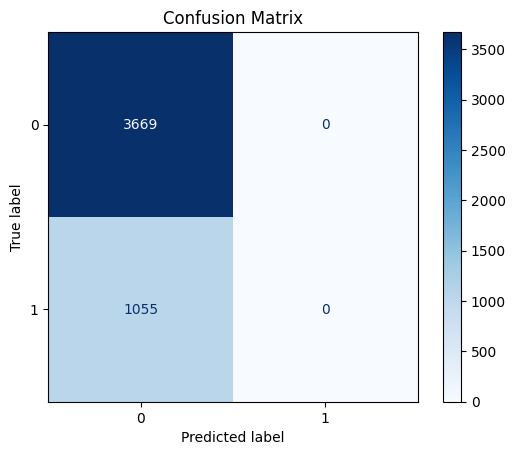

In [ ]:
from sklearn.metrics import roc_curve, auc, brier_score_loss, f1_score, precision_recall_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_performance(y_true, y_pred_prob, y_pred, n_bootstraps=1000, alpha=0.95):
    """
    Evaluate the performance of a model, including ROC AUC, Brier Score, F1 Score, and 95% Confidence Interval for F1 Score.

    Parameters:
    - y_true: True labels.
    - y_pred_prob: Predicted probabilities for the positive class.
    - y_pred: Predicted class labels.
    - n_bootstraps: Number of bootstraps for confidence interval calculation.
    - alpha: Confidence level for F1 score confidence intervals.
    """

    # Calculate Area Under ROC Curve
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    # Calculate Brier Score
    brier = brier_score_loss(y_true, y_pred_prob)

    # Calculate F1 Score
    f1 = f1_score(y_true, y_pred)

    # Calculate 95% Confidence Interval for F1 Score
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = resample(np.arange(len(y_pred)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = f1_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower = sorted_scores[int((1.0-alpha)/2.0 * len(sorted_scores))]
    upper = sorted_scores[int((alpha+(1.0-alpha)/2.0) * len(sorted_scores))]

    # Display metrics
    print(f"Area Under ROC Curve: {roc_auc:.2f}")
    print(f"Brier Score: {brier:.3f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"95% Confidence Interval for F1 Score: [{lower:.2f}, {upper:.2f}]")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Convert predictions to NumPy arrays if they are not already
y_test_array = np.array(y_test_final)
predictions_rf_array = np.array(y_prob_rf_final).flatten()
y_pred_rf_array = np.array(y_pred_rf_final)

# Call the evaluation function
evaluate_model_performance(y_test_array, predictions_rf_array, y_pred_rf_array)

In [ ]:
import dice_ml
from dice_ml import Dice
import tensorflow as tf
import pandas as pd


class WrappedTFDFModel:
    def __init__(self, tfdf_model, feature_names):
        self.model = tfdf_model
        self.feature_names = feature_names

    def __call__(self, x, **kwargs):
        return self.predict(x)

    def predict(self, x):
        # Convert the input array into a dictionary
        if isinstance(x, pd.DataFrame):
            input_dict = {col: tf.convert_to_tensor(x[col].values) for col in self.feature_names}
        else:
            input_dict = {col: tf.convert_to_tensor(x[:, i]) for i, col in enumerate(self.feature_names)}
        predictions = self.model(input_dict)
        return predictions


# Assuming X_train, X_test, y_train, y_test, and rf_model are already defined
# Ensure that X_train, X_test, X_validation are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')

# Ensure that y_train, y_test, y_validation are float32 or int32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_validation = y_validation.astype('float32')

# Re-attach the 'aki_stage' to the DataFrame
X_train_with_label = X_train.copy()
X_train_with_label['aki_stage'] = y_train

X_test_with_label = X_test.copy()
X_test_with_label['aki_stage'] = y_test

# Prepare DiCE data object with original feature names
data = dice_ml.Data(dataframe=X_train_with_label, continuous_features=list(X_train.columns), outcome_name='aki_stage')

# Wrap the TFDF model
wrapped_model = WrappedTFDFModel(rf_model_final, feature_names=list(X_train.columns))

# Prepare DiCE model object using the wrapped TFDF model
dice_model = dice_ml.Model(model=wrapped_model, backend="TF2")

# Create a DiCE explainer with the original data and model
explainer = Dice(data, dice_model)

# Select a specific instance from X_test (e.g., the 36th instance)
instance_index = 0  # Change this to select a different instance
query_instance_df = X_test.iloc[[instance_index]]

# Generate counterfactual explanations using the original model and data
counterfactuals = explainer.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")

# Print the counterfactuals if generated
if counterfactuals.cf_examples_list[0].final_cfs_df is not None:
    print(counterfactuals.cf_examples_list[0].final_cfs_df)
else:
    print("No Counterfactuals found for the given configuration.")


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will ra

     F    M  asian  black  hispanic  native  other  unknown  white  sedative   
0  0.0  1.0    0.0    0.0       0.0     0.0    0.0      0.0    1.0       0.9  \
1  0.0  1.0    0.0    0.0       0.0     0.0    1.1      0.0    1.0       0.9   
2  0.0  1.0    0.0    0.0       0.6     0.0    1.1      0.0    1.0       0.9   
3  0.0  1.0    0.0    0.5       0.0     0.0    0.0      0.0    1.0       0.0   
4  0.0  1.0    0.0    0.0       0.0     0.8    0.0      0.0    1.0       0.5   

   ...  resprate_mean  sodium_avg  spo2_mean  sysbp_mean  uo_rt_12hr   
0  ...       0.239891    0.278359   1.000000    0.221763    0.110847  \
1  ...       0.239891    0.278359   1.000000    0.221763    0.110847   
2  ...       0.239891    0.278359   1.000000    0.221763    0.110847   
3  ...       0.239891    0.278359   0.800000    0.221763    0.110847   
4  ...       0.600000    0.278359   0.328167    1.000000    0.110847   

   uo_rt_24hr  uo_rt_6hr   wbc_avg       age  aki_stage  
0    0.119538   0.095468  0.

In [ ]:
counterfactuals.visualize_as_dataframe(show_only_changes=True)
# Access the counterfactual examples as a pandas DataFrame
counterfactuals_df = counterfactuals.cf_examples_list[0].final_cfs_df

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(counterfactuals_df)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.239891,0.278359,0.328167,0.221763,0.110847,0.119538,0.095468,0.150376,0.381185,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,-,-,-,-,-,0.8999999761581421,...,-,-,1.0,-,-,-,-,-,0.6000000238418579,1.0
1,-,-,-,-,-,-,1.100000023841858,-,-,0.8999999761581421,...,-,-,1.0,-,-,-,-,-,0.6000000238418579,1.0
2,-,-,-,-,0.6000000238418579,-,1.100000023841858,-,-,0.8999999761581421,...,-,-,1.0,-,-,-,-,-,0.6000000238418579,1.0
3,-,-,-,0.5,-,-,-,-,-,-,...,-,-,0.800000011920929,-,-,0.699999988079071,-,-,0.800000011920929,1.0
4,-,-,-,-,-,0.800000011920929,-,-,-,2.7755575615628914e-17,...,0.6000000238418579,-,-,1.0,-,-,-,-,-,1.0


    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.9        0.0       1.0  \
1  0.0  1.0   0.0    0.0      0.0      0.0    1.1     0.0     1.0      0.9        0.0       1.0   
2  0.0  1.0   0.0    0.0      0.6      0.0    1.1     0.0     1.0      0.9        0.0       1.0   
3  0.0  1.0   0.0    0.5      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
4  0.0  1.0   0.0    0.0      0.0      0.8    0.0     0.0     1.0      0.5        0.0       0.0   

   aniongap_avg  bicarbonate_avg   bun_avg  chloride_avg    creat   diasbp_mean  glucose_avg   
0    0.177733       0.214487      0.608174     0.26797    0.702981   0.242791     0.200368    \
1    0.177733       0.214487      0.608174     0.26797    0.702981   0.242791     0.200368     
2    0.177733       0.214487      0.608174     0.26797    0.702981   0.242791     0.200368     
3    0.177733       0

In [ ]:
# Generate counterfactuals with custom proximity and diversity weights
cf_desired_standardized = explainer.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite", proximity_weight=0.5, diversity_weight=0.5 )
# Access the counterfactual examples as a pandas DataFrame
cf_desired_standardized_df = cf_desired_standardized.cf_examples_list[0].final_cfs_df
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(cf_desired_standardized_df)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will ra

    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.0    0.0      0.0      0.9    0.0     0.0     1.0      0.7        0.7       0.0  \
1  0.1  0.0   0.0    0.9      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
2  0.0  1.0   0.0    0.0      0.0      0.0    0.8     0.0     0.9      0.3        0.0       0.0   
3  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
4  0.0  1.0   0.9    0.0      0.0      0.0    0.0     0.6     1.0      0.0        0.0       0.9   

   aniongap_avg  bicarbonate_avg   bun_avg  chloride_avg    creat   diasbp_mean  glucose_avg   
0    0.177733       0.214487      0.059863     0.26797    0.999215   0.242791     0.300000    \
1    0.177733       0.214487      0.031615     0.70000    0.033269   0.242791     0.200368     
2    0.177733       0.214487      0.031615     0.26797    0.432677   0.600000     0.200368     
3    0.177733       0

In [ ]:
# Attempt to generate counterfactuals with fewer constraints
cf_desired_factor_standardized = explainer.generate_counterfactuals(query_instance_df,total_CFs=10, desired_class="opposite", features_to_vary='all', proximity_weight=0.1, diversity_weight=0.1)

# Visualize the counterfactuals as a dataframe, showing only the changes
cf_desired_factor_standardized.visualize_as_dataframe(show_only_changes=True)
# Access the counterfactual examples as a pandas DataFrame
cf_desired_factor_standardized_df = cf_desired_factor_standardized.cf_examples_list[0].final_cfs_df

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure the display is wide enough
pd.set_option('display.colheader_justify', 'center')  # Center-align the headers

# Display the full DataFrame
print(cf_desired_factor_standardized_df)

# Reset the options to their defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.colheader_justify')

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.61659152' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
/usr/local/lib/python3.10/dist-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and 

Query instance (original outcome : 0)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.239891,0.278359,0.328167,0.221763,0.110847,0.119538,0.095468,0.150376,0.381185,0



Diverse Counterfactual set (new outcome: 1)


,F,M,asian,black,hispanic,native,other,unknown,white,sedative,...,resprate_mean,sodium_avg,spo2_mean,sysbp_mean,uo_rt_12hr,uo_rt_24hr,uo_rt_6hr,wbc_avg,age,aki_stage
0,-,-,-,-,-,-,1.100000023841858,-,-,-,...,0.5,0.4178728461265564,1.100000023841858,0.8999999761581421,-,-,-,-,0.30000001192092896,1.0
1,-,-,-,-,-,-,-,-,-,-,...,0.699999988079071,-,1.100000023841858,-,-,-,-,0.8999999761581421,-,1.0
2,-,-,2.7755575615628914e-17,2.7755575615628914e-17,-,-,-,-,-,-,...,0.8999999761581421,-,0.699999988079071,0.5,-,-,-,-,0.8999999761581421,1.0
3,-,-,-,-,-,-,1.100000023841858,-,-,-,...,0.5,-,1.100000023841858,0.8999999761581421,-,-,-,-,0.30000001192092896,1.0
4,-,-,-,-,-,-,-,-,-,-,...,0.699999988079071,-,1.100000023841858,-,-,-,-,0.8999999761581421,-,1.0
5,-,-,-,1.0,-,-,-,-,-,-,...,1.100000023841858,-,0.8999999761581421,-,-,-,-,0.6000000238418579,-,1.0
6,-,-,-,-,-,-,-,-,-,-,...,-,-,0.699999988079071,0.6000000238418579,-,-,-,0.6000000238418579,0.30000001192092896,1.0
7,-,0.0,-,-,-,-,-,0.699999988079071,-,-,...,-,-,0.699999988079071,0.6000000238418579,-,-,-,0.6000000238418579,0.30000001192092896,1.0
8,-,-,-,-,-,-,-,-,-,-,...,0.699999988079071,-,1.100000023841858,-,-,-,-,0.8999999761581421,-,1.0
9,-,-,-,-,-,-,-,-,-,-,...,0.699999988079071,-,1.100000023841858,-,-,-,-,-,-,1.0


    F    M   asian  black  hispanic  native  other  unknown  white  sedative  vasopressor  vent   
0  0.0  1.0   0.1    0.0      0.0      0.0    1.1     0.0     1.0      0.0        0.9       0.0  \
1  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
2  0.0  1.0   0.5    0.5      0.0      0.0    0.0     0.1     1.0      0.0        0.0       0.0   
3  0.0  1.0   0.1    0.0      0.0      0.0    1.1     0.0     1.0      0.0        0.9       0.0   
4  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
5  0.0  1.0   0.0    1.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
6  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
7  0.0  0.0   0.0    0.0      0.0      0.0    0.0     0.7     1.0      0.0        0.0       0.0   
8  0.0  1.0   0.0    0.0      0.0      0.0    0.0     0.0     1.0      0.0        0.0       0.0   
9  0.0  1.